# Project: Wrangling and Analyze Data

Table Contents
- I. Introduction
- II. Data Gathering
- III. Data Assessing
- IV. Data Cleaning
- V. Storing Data
- VI. Analyzing and Visualizing Data

## I. Introduction

In [1226]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline

## II. Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1227]:
twitter_archive_enhanced = pd.read_csv('twitter-archive-enhanced.csv')

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [1228]:
# Import the requests library
import requests

In [1229]:
# Download a File from a URL
URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(URL)

#  Open the response into a new file called image-predictions.tsv
open('image_predictions.tsv', mode = 'wb').write(response.content)
    
# Read TSV file
image_prediction = pd.read_csv('image_predictions.tsv', sep = '\t')
image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [1230]:
# Download a File from a URL
URL = 'https://video.udacity-data.com/topher/2018/November/5be5fb7d_tweet-json/tweet-json.txt'
response = requests.get(URL)

#  Open the response into a new file called tweet_json.txt
open('tweet_json.txt', mode = 'wb').write(response.content)

10609234

In [1231]:
# Read tweet_json.txt file
data = []
with open('tweet_json.txt', 'r') as f:
    lines = f.readlines()
    for i in lines:
        value = json.loads(i)
        data.append({'tweet_id': value['id'],
                   'favorite_count': value['favorite_count'],
                   'retweet_count': value['retweet_count']})
        
tweet_json = pd.DataFrame(data, columns = ['tweet_id', 'favorite_count', 'retweet_count'])
tweet_json.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774


## III. Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



- **Dirty data** which has issues with its content is often called low-quality data and can include things like inaccurate data, corrupted data, and duplicate data.
- **Messy data** has issues with its structure. It is often referred to as untidy.


### Assessing twitter_archive_enhanced table

In [1232]:
twitter_archive_enhanced

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [1233]:
twitter_archive_enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [1234]:
twitter_archive_enhanced[twitter_archive_enhanced.in_reply_to_status_id.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [1235]:
twitter_archive_enhanced.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [1236]:
twitter_archive_enhanced.text.sample(50)

1095    Say hello to mad pupper. You know what you did...
2049    This is Charlie. He was just informed that dog...
1515    We've got a doggy down. Requesting backup. 12/...
446     RT @dog_rates: This is Bo. He was a very good ...
2105    Honor to rate this dog. Great teeth. Nice horn...
1842    &amp; this is Yoshi. Another world record cont...
1926    This is Stanley. Yes he is aware of the spoon'...
1653    "Hello forest pupper I am house pupper welcome...
1270    Meet Karma. She's just a head. Lost body durin...
310     RT @dog_rates: So this just changed my life. 1...
1966    IT'S SO SMALL ERMERGERF 11/10 https://t.co/dNU...
720     RT @dog_rates: This is Kenny. He just wants to...
1516    This golden is happy to refute the soft mouth ...
1201    This is Ozzy. He's acrobatic af. Legendary pup...
1254    Here's a brigade of puppers. All look very pre...
1575    This is Curtis. He's a fluffball. 11/10 would ...
2244    This is Erik. He's fucken massive. But also ki...
2039    This i

In [1237]:
twitter_archive_enhanced.tweet_id.duplicated().sum()

0

In [1238]:
twitter_archive_enhanced.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [1239]:
twitter_archive_enhanced.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
2         9
1         9
75        2
15        2
420       2
0         2
80        1
144       1
17        1
26        1
20        1
121       1
143       1
44        1
60        1
45        1
50        1
99        1
204       1
1776      1
165       1
666       1
27        1
182       1
24        1
960       1
84        1
88        1
Name: rating_numerator, dtype: int64

In [1240]:
twitter_archive_enhanced.rating_numerator.sort_values()

315        0
1016       0
2335       1
2261       1
2338       1
        ... 
2074     420
188      420
189      666
313      960
979     1776
Name: rating_numerator, Length: 2356, dtype: int64

In [1241]:
twitter_archive_enhanced.rating_denominator.value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [1242]:
twitter_archive_enhanced.rating_denominator.sort_values()

313       0
2335      2
516       7
1576     10
1575     10
       ... 
1635    110
1779    120
1634    130
902     150
1120    170
Name: rating_denominator, Length: 2356, dtype: int64

In [1243]:
twitter_archive_enhanced.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Lucy           11
             ... 
Dex             1
Ace             1
Tayzie          1
Grizzie         1
Christoper      1
Name: name, Length: 957, dtype: int64

In [1244]:
twitter_archive_enhanced.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [1245]:
twitter_archive_enhanced.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [1246]:
twitter_archive_enhanced.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [1247]:
twitter_archive_enhanced.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

### Assessing image_predictions table

In [1248]:
image_prediction

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [1249]:
image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [1250]:
image_prediction.tweet_id.duplicated().sum()

0

In [1251]:
image_prediction.jpg_url.duplicated().sum()

66

In [1252]:
image_prediction.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [1253]:
image_prediction.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
pillow                  1
carousel                1
bald_eagle              1
lorikeet                1
orange                  1
Name: p1, Length: 378, dtype: int64

In [1254]:
image_prediction.p2.value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
medicine_chest          1
quail                   1
horse_cart              1
waffle_iron             1
bagel                   1
Name: p2, Length: 405, dtype: int64

In [1255]:
image_prediction.p3.value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
ox                     1
assault_rifle          1
axolotl                1
pot                    1
banana                 1
Name: p3, Length: 408, dtype: int64

In [1256]:
image_prediction.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [1257]:
image_prediction.p2_dog.value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [1258]:
image_prediction.p3_dog.value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

### Assessing tweet_json table

In [1259]:
tweet_json

,tweet_id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774
...,...,...,...
2349,666049248165822465,111,41
2350,666044226329800704,311,147
2351,666033412701032449,128,47
2352,666029285002620928,132,48


In [1260]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   favorite_count  2354 non-null   int64
 2   retweet_count   2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [1261]:
tweet_json.tweet_id.duplicated().sum()

0

### Quality issues
1. Columns: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls are missing the value.

2. Data type of these columns: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id are float, it should be object.

3. timestamp is object, it should be datetime dtype.

4. Remove retweets and replies data only keep the original tweets, and some tweets has the HTML code, so that needs to be cleaned up.

5. I see in the name column have some name like a, an, the, I think maybe they are not the real name.

6. Columns name missing the name, and these name has some uppercase and lowercase letters. It should be consistent, I will uppercase them.

7. These columns p1, p2, and p3 had some uppercase and lowercase letters.

8. jpg_url column has duplicated value
9. Many entries are not dogs base on p1, p2. p3

### Tidiness issues
1. I think these columns: doggo, floofer, pupper, puppo should be in one columns.

2. The source column looks messy.
3. We should merge 3 table base on tweet_id, and remove unncessary columns.

## IV. Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [1262]:
# Make copies of original pieces of data
twitter_archive_enhanced_clean = twitter_archive_enhanced.copy()
image_prediction_clean = image_prediction.copy()
tweet_json_clean = tweet_json.copy()

### Issue #1:  twitter_archive_enhanced_clean: Remove retweet and replies data

#### Define: 
To remove retweet and replies data, select all rows with NaN by using syntax **isna()**

#### Code

In [1263]:
#Remove retweet data
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean[twitter_archive_enhanced_clean['retweeted_status_id'].isna()]
#Remove replies data
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean[twitter_archive_enhanced_clean['in_reply_to_status_id'].isna()]

#### Test

In [1264]:
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

### Issue #2: twitter_archive_enhanced_clean: Remove columns relates retweet and reply

#### Define
 Use **for** loop and function **del** to delete columns relate retweeted and reply 

#### Code

In [1265]:
for col in twitter_archive_enhanced_clean.columns:
    if 'reply' in col:
        del twitter_archive_enhanced_clean[col]
    elif 'retweeted'in col:
        del twitter_archive_enhanced_clean[col]

#### Test

In [1266]:
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2097 non-null   int64 
 6   rating_denominator  2097 non-null   int64 
 7   name                2097 non-null   object
 8   doggo               2097 non-null   object
 9   floofer             2097 non-null   object
 10  pupper              2097 non-null   object
 11  puppo               2097 non-null   object
dtypes: int64(3), object(9)
memory usage: 213.0+ KB


### Issue #3: twitter_archive_enhanced_clean: Remove row in all columns have NaN values or missing values

#### Define
Using syntax **dropna** to remove these row have NaN values from all columns


#### Code

In [1267]:
twitter_archive_enhanced_clean.dropna(axis='columns', how ='any', inplace = True)

#### Test

In [1268]:
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   rating_numerator    2097 non-null   int64 
 5   rating_denominator  2097 non-null   int64 
 6   name                2097 non-null   object
 7   doggo               2097 non-null   object
 8   floofer             2097 non-null   object
 9   pupper              2097 non-null   object
 10  puppo               2097 non-null   object
dtypes: int64(3), object(8)
memory usage: 196.6+ KB


### Issue #4: twitter_archive_enhanced_clean: Fixing data type of timestamp to datetime

#### Define
Using **Series.astype() method**  to convert timestamp to datetime

#### Code


In [1269]:
#Import Datetime
from datetime import datetime

In [1270]:
twitter_archive_enhanced_clean['timestamp'] = twitter_archive_enhanced_clean['timestamp'].astype('datetime64[ns]')

In [1271]:
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2097 non-null   int64         
 1   timestamp           2097 non-null   datetime64[ns]
 2   source              2097 non-null   object        
 3   text                2097 non-null   object        
 4   rating_numerator    2097 non-null   int64         
 5   rating_denominator  2097 non-null   int64         
 6   name                2097 non-null   object        
 7   doggo               2097 non-null   object        
 8   floofer             2097 non-null   object        
 9   pupper              2097 non-null   object        
 10  puppo               2097 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 196.6+ KB


In [1272]:
twitter_archive_enhanced_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


### Issue #5: twitter_archive_enhanced_clean: Clean up text column

#### Define

Write for loop to clean up text in column by using **Orderedict** and **replace()** method

#### Code

In [1273]:
from collections import OrderedDict

In [1274]:
dic = OrderedDict([("&amp;", "&"), ("\n", " "), (r"http\S+", " "), (":", " "), (".", " "), ("'s", " ")])
for i, j in dic.items():
    twitter_archive_enhanced_clean['text'] = twitter_archive_enhanced_clean['text'].str.replace(i, j, regex=True)

#### Test

In [1275]:
twitter_archive_enhanced_clean['text'].sample(20)

1093    Everybody stop what you're doing and watch the...
643     Say hello to Lily  She  pupset that her costum...
1952    This is Shnuggles  I would kill for Shnuggles ...
2159    This is Keith  He  had 13 DUIs  7/10 that  too...
1912    This is Gary  He  a hide and seek champion  Se...
42      OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LIT...
2076    Pink dogs here  Unreasonably long necks  Left ...
1467    Meet Grady  He  very hungry  Too bad no one ca...
311     Meet Ash  He  a Benebop Cumberplop  Quite rare...
2090    This is Creg  You offered him a ride to work b...
832     Say hello to Oakley and Charlie  They're convi...
896     Meet Toby  He has a drinking problem  Inflatab...
301     Say hello to Oliver  He  pretty exotic  Fairly...
1590    This is Olivia  She just saw an adult wearing ...
417     This is Paisley  She really wanted to be presi...
758     RIP Loki  Thank you for the good times  You wi...
2124    Meet Daisy  She  rebellious  Full of teen angs...
768     This i

### Issue #6: twitter_archive_enhanced_clean: Remove these rows have meaningless name in column name. Capitalize the name

#### Define
- Using ne() to compare row with specific value and delete rows based on column value.
- Using capitalize() method is used to capitalize the current string

#### Code


In [1276]:
df = twitter_archive_enhanced_clean
df = df[df['name'].ne("a") & df['name'].ne("an") & df['name'].ne("the") & df['name'].ne("O")]
twitter_archive_enhanced_clean = df

In [1277]:
twitter_archive_enhanced_clean['name'] = twitter_archive_enhanced_clean['name'].str.capitalize()

#### Test


In [1278]:
twitter_archive_enhanced_clean.name.value_counts()

None          603
Lucy           11
Charlie        11
Oliver         10
Cooper         10
             ... 
Wishes          1
Rose            1
Theo            1
Fido            1
Christoper      1
Name: name, Length: 951, dtype: int64

In [1279]:
twitter_archive_enhanced_clean.name.sample(50)

104         Harry
1106         None
1170     Berkeley
93           None
987      Dietrich
468         Chloe
1145        Karll
361           Leo
1658        Larry
1718         None
1070        Chase
1793     Humphrey
1248         None
2081         None
1011        Linus
736          None
1241      Chester
383       Charlie
977         Piper
1784         None
1599         None
989        Divine
1700        Ozzie
1728        Rocco
1427         None
757         Penny
553            Bo
578         Mauve
1584         None
1960         None
928         Keith
1988           Ed
2226       Sophie
852            My
1617      Gerbald
995          None
679            Bo
1723         None
1910        Jonah
1952    Shnuggles
464       Strudel
1682      Charlie
1234         None
254       Charlie
2310         None
1771        Rosie
1748     Chompsky
226          None
129        Shikha
1470      Chester
Name: name, dtype: object

### Issue 7#: image_prediction_clean: Capitalize value from columns p1, p2, and p3

#### Define
Using capitalize() method is used to capitalize the current string

#### Code

In [1280]:
# Remove _ character and capitablize value columns p1
image_prediction_clean['p1'] = image_prediction_clean['p1'].str.replace("_", " ")
image_prediction_clean['p1'] = image_prediction_clean['p1'].str.title()

# Remove _ character and capitablize value columns p2
image_prediction_clean['p2'] = image_prediction_clean['p2'].str.replace("_", " ")
image_prediction_clean['p2'] = image_prediction_clean['p2'].str.title()

# Remove _ character and capitablize value columns p3
image_prediction_clean['p3'] = image_prediction_clean['p3'].str.replace("_", " ")
image_prediction_clean['p3'] = image_prediction_clean['p3'].str.title()

#### Test

In [1281]:
image_prediction_clean.p1.value_counts()

Golden Retriever      150
Labrador Retriever    100
Pembroke               89
Chihuahua              83
Pug                    57
                     ... 
Pillow                  1
Carousel                1
Bald Eagle              1
Lorikeet                1
Orange                  1
Name: p1, Length: 378, dtype: int64

In [1282]:
image_prediction_clean.p2.value_counts()

Labrador Retriever    104
Golden Retriever       92
Cardigan               74
Chihuahua              44
Pomeranian             42
                     ... 
Horse Cart              1
Tray                    1
Pier                    1
Red Fox                 1
Bagel                   1
Name: p2, Length: 404, dtype: int64

In [1283]:
image_prediction_clean.p3.value_counts()

Labrador Retriever    79
Chihuahua             58
Golden Retriever      48
Eskimo Dog            38
Kelpie                35
                      ..
Ox                     1
Assault Rifle          1
Axolotl                1
Pot                    1
Banana                 1
Name: p3, Length: 408, dtype: int64

### Issue 8#: image_prediction_clean: Remove rows are not dogs

####  Define
Base on value of p1_dog, p2_dog, p3_dog

#### Code

In [1284]:
df = image_prediction_clean
df = df[df['p1_dog'].ne(False) & df['p2_dog'].ne(False) & df['p3_dog'].ne(False)]
image_prediction_clean = df

#### Test

In [1285]:
image_prediction_clean.p1_dog.value_counts()

True    1243
Name: p1_dog, dtype: int64

In [1286]:
image_prediction_clean.p2_dog.value_counts()

True    1243
Name: p2_dog, dtype: int64

In [1287]:
image_prediction_clean.p3_dog.value_counts()

True    1243
Name: p3_dog, dtype: int64

### Issue 9#: image_prediction_clean: Create a new column breed to combine p1, p2, p3 in one columns

#### Define 

- Create a new column breed, and confident level base on columns p1_dog, p2_dog, p3_dog.
- p1 is the most confident level, in the previous step we already remove rows are not dog base on True value, so we only need get the value from p1 column to create bread columns
- Remove column p1_dog	p2_conf	p2_dog	p3_conf	p3_dog

In [1288]:
image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 2073
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1243 non-null   int64  
 1   jpg_url   1243 non-null   object 
 2   img_num   1243 non-null   int64  
 3   p1        1243 non-null   object 
 4   p1_conf   1243 non-null   float64
 5   p1_dog    1243 non-null   bool   
 6   p2        1243 non-null   object 
 7   p2_conf   1243 non-null   float64
 8   p2_dog    1243 non-null   bool   
 9   p3        1243 non-null   object 
 10  p3_conf   1243 non-null   float64
 11  p3_dog    1243 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 100.8+ KB


In [1289]:
#Rename column p1 to breed, p1_conf to confident_rate
image_prediction_clean.rename(columns = {'p1':'breed', 'p1_conf':'confident_rate'}, inplace = True)
# Drop columns no longer needed
image_prediction_clean = image_prediction_clean.drop(['img_num','p1_dog',
                                                      'p2','p2_conf','p2_dog',
                                                      'p3','p3_conf','p3_dog'],axis=1)

In [1290]:
image_prediction_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1243 entries, 0 to 2073
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        1243 non-null   int64  
 1   jpg_url         1243 non-null   object 
 2   breed           1243 non-null   object 
 3   confident_rate  1243 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 48.6+ KB


### Issue 10#: doggo, floofer, pupper, puppo are all stages of dog, should be in one column

#### Define
Use method melt() to melt doggo, floofer, pupper, puppo in one column

#### Code

In [1291]:
# Melt the doggo, floofer, pupper and puppo columns as dog_stages column
df = twitter_archive_enhanced_clean
df = pd.melt(df, id_vars = ['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator', 'rating_denominator', 'name'],
               value_vars = ['doggo', 'floofer', 'pupper', 'puppo'],
                 var_name = 'variable',
               value_name = 'dog_stages')
#Drop columns variable
del df['variable']
# Sort by dog_stage and drop duplicates
twitter_archive_enhanced_clean = df
twitter_archive_enhanced_clean = twitter_archive_enhanced_clean.sort_values('dog_stages').drop_duplicates(subset='tweet_id', keep='last')

#### Test

In [1292]:
twitter_archive_enhanced_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stages
1955,667534815156183040,2015-11-20 02:47:56,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","This is Frank (pronounced ""Fronq"") Too many b...",8,10,Frank,None
1954,667544320556335104,2015-11-20 03:25:43,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","This is Kial Kial is either wearing a cape, w...",10,10,Kial,None
1953,667546741521195010,2015-11-20 03:35:20,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Here is George George took a selfie of his ne...,9,10,George,None
1952,667549055577362432,2015-11-20 03:44:31,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Never seen dog like this Breathes heavy Tilt...,1,10,None,None
1951,667724302356258817,2015-11-20 15:20:54,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",What a dog to start the day with Very calm L...,7,10,None,None


In [1293]:
twitter_archive_enhanced_clean.dog_stages.value_counts()

None       1697
pupper      224
doggo        72
puppo        24
floofer      10
Name: dog_stages, dtype: int64

### Issue 11#: Source looks messy, remove unnessary link, href

#### Define

Using BeautifulSoup and appyly function to extract text from column source

#### Code

In [1294]:
from bs4 import BeautifulSoup

In [1295]:
twitter_archive_enhanced_clean['source'] = twitter_archive_enhanced_clean['source'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

#### Test

In [1296]:
twitter_archive_enhanced_clean.head()

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,dog_stages
1955,667534815156183040,2015-11-20 02:47:56,Twitter Web Client,"This is Frank (pronounced ""Fronq"") Too many b...",8,10,Frank,None
1954,667544320556335104,2015-11-20 03:25:43,Twitter Web Client,"This is Kial Kial is either wearing a cape, w...",10,10,Kial,None
1953,667546741521195010,2015-11-20 03:35:20,Twitter Web Client,Here is George George took a selfie of his ne...,9,10,George,None
1952,667549055577362432,2015-11-20 03:44:31,Twitter Web Client,Never seen dog like this Breathes heavy Tilt...,1,10,None,None
1951,667724302356258817,2015-11-20 15:20:54,Twitter Web Client,What a dog to start the day with Very calm L...,7,10,None,None


In [1297]:
twitter_archive_enhanced_clean.source.value_counts()

Twitter for iPhone     1898
Vine - Make a Scene      90
Twitter Web Client       28
TweetDeck                11
Name: source, dtype: int64

In [1298]:
twitter_archive_enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2027 entries, 1955 to 6603
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            2027 non-null   int64         
 1   timestamp           2027 non-null   datetime64[ns]
 2   source              2027 non-null   object        
 3   text                2027 non-null   object        
 4   rating_numerator    2027 non-null   int64         
 5   rating_denominator  2027 non-null   int64         
 6   name                2027 non-null   object        
 7   dog_stages          2027 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 142.5+ KB


### Merge 3 table twitter_archive_enhanced_clean, image_prediction_clean, and tweet_json_clean

In [1299]:
df_twitter_image = pd.merge(twitter_archive_enhanced_clean, image_prediction_clean, how = 'left', on = ['tweet_id'])

In [1300]:
df_new = pd.merge(df_twitter_image, tweet_json_clean, how = 'left', on = ['tweet_id'])

In [1301]:
df_new = df_new[df_new['jpg_url'].notnull()]

In [1302]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1154 entries, 0 to 2026
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1154 non-null   int64         
 1   timestamp           1154 non-null   datetime64[ns]
 2   source              1154 non-null   object        
 3   text                1154 non-null   object        
 4   rating_numerator    1154 non-null   int64         
 5   rating_denominator  1154 non-null   int64         
 6   name                1154 non-null   object        
 7   dog_stages          1154 non-null   object        
 8   jpg_url             1154 non-null   object        
 9   breed               1154 non-null   object        
 10  confident_rate      1154 non-null   float64       
 11  favorite_count      1154 non-null   int64         
 12  retweet_count       1154 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5), obje

## V. Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [1303]:
# Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".
df_new.to_csv('twitter_archive_master.csv')
# Read CSV twitter_archive_master file
df = pd.read_csv('twitter_archive_master.csv')

## VI. Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [1304]:
import seaborn as sns

Top 10 Popular Breeds Based On The Number Of Tweet
Golden Retriever      115
Pembroke               74
Labrador Retriever     73
Chihuahua              50
Pug                    38
Pomeranian             27
Chow                   25
Malamute               25
Samoyed                24
Toy Poodle             24
dtype: int64


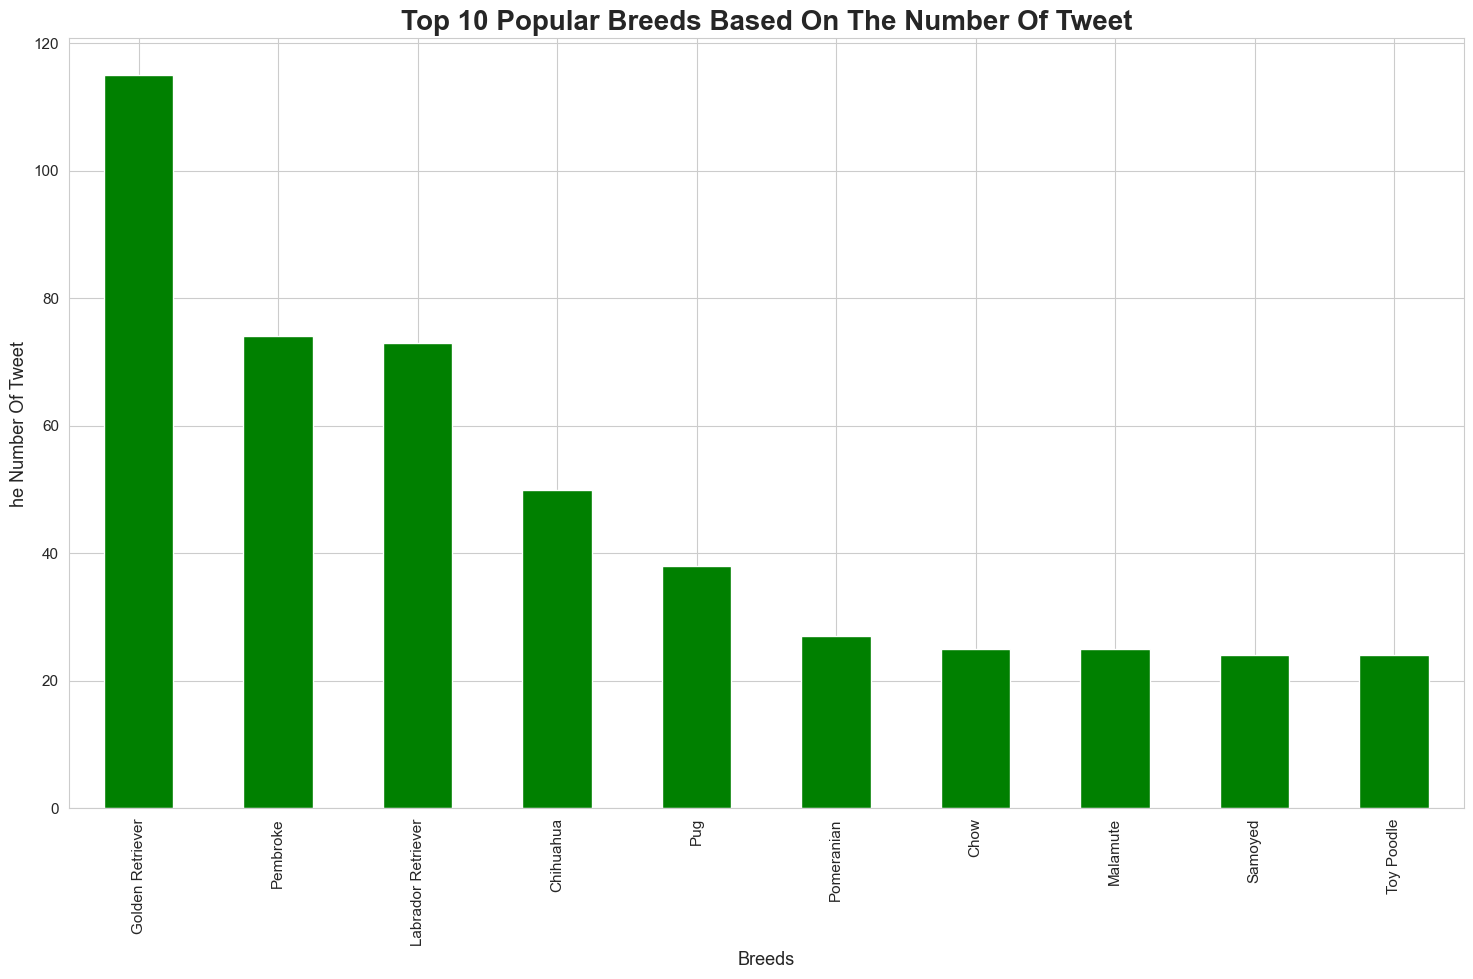

In [1305]:
def count_total_breed(x):
    #concatenate all the rows of the breed.
    twitter_data_plot = df[x].str.cat(sep = '|')
    twitter_data = pd.Series(twitter_data_plot.split('|'))
    breed = twitter_data.value_counts()
    return breed
# Get Top 10 Popular Breeds Based On The Number Of Tweet
print('Top 10 Popular Breeds Based On The Number Of Tweet')
total_breed = count_total_breed('breed').head(10)
print(total_breed)

# Plot a 'bar' plot using plot function
total_breed.plot(kind = 'bar',figsize = (18,10), fontsize = 11, color = "green")

# Setup the title and the labels of the plot.
plt.title("Top 10 Popular Breeds Based On The Number Of Tweet", fontsize = 20, weight = 'bold')
plt.xlabel('Breeds', fontsize = 13)
plt.ylabel("he Number Of Tweet", fontsize = 13)
sns.set_style("whitegrid")


### Insights 1:


From the chart we can see top 10 popular breeds, in which, Golden Retriever is the best popular breeds (115 tweets), next is Pembroke with 74 tweets, and top 3 is Labrador Retriever with 73 tweets.

Top 10 Favorite Breeds Based On The Number Of Favorite Tweet
breed
Golden Retriever      1431741
Pembroke               926221
Labrador Retriever     738258
Chihuahua              457182
French Bulldog         372420
Samoyed                357148
Chow                   288792
Cocker Spaniel         258850
Malamute               223074
Pug                    221355
Name: favorite_count, dtype: int64


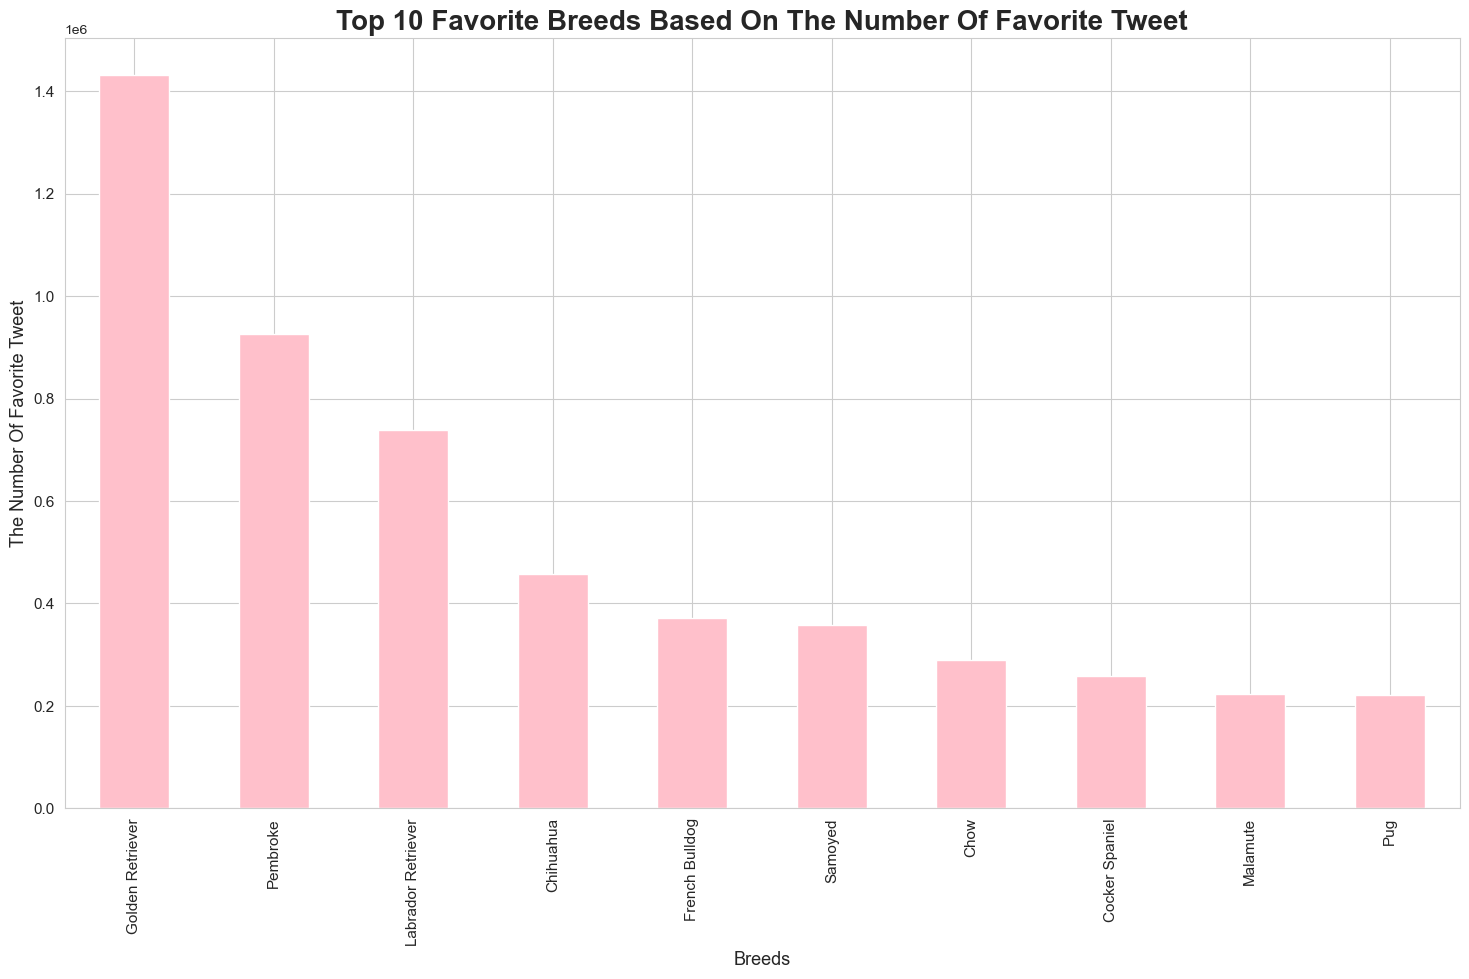

In [1306]:
# Get Top 10 breeds based on the number of favorite tweet
total_breed_favor = df.groupby('breed')['favorite_count'].agg('sum').sort_values(ascending = True).nlargest(n=10)

print('Top 10 Favorite Breeds Based On The Number Of Favorite Tweet')
print(total_breed_favor)

# Plot a 'bar' plot using plot function
total_breed_favor.plot(kind = 'bar',figsize = (18,10), fontsize = 11, color = "pink")

# Setup the title and the labels of the plot.
plt.title("Top 10 Favorite Breeds Based On The Number Of Favorite Tweet", fontsize = 20, weight = 'bold')
plt.xlabel('Breeds', fontsize = 13)
plt.ylabel("The Number Of Favorite Tweet", fontsize = 13)
sns.set_style("whitegrid")

### Insights 2:

From the chart we can see top 10 popular breeds, in which, Golden Retriever is the best favorite breeds (1,431,741 favorite tweets), next is Pembroke, and top 3 is Labrador Retriever.

### Insights 3:

From above charts, I think Golden Retriever is the best favorite of breed dog. Base on my knowledge, Golden Retriever is friendly, smart, and hard-working. I think these are some reason why Golden Retriever is a popular and favorite breed dog.

## What does people think about top 3 breeds:  Golden Retriever, Labrador Retriever, and Pembroke

#### Define

- I will get data from top 3 dogs, and then using work cloud to visualize what they say about 3 breeds

#### Code

In [1307]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [1308]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [1309]:
# Get tweet relate 3 breeds: Golden Retriever, Labrador Retriever, and Pembroke
df_word = df.loc[df['breed'].eq("Golden Retriever") | df['breed'].eq("Pembroke") | df['breed'].eq("Labrador Retriever")]

In [1310]:
df_word.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262 entries, 0 to 1152
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          262 non-null    int64  
 1   tweet_id            262 non-null    int64  
 2   timestamp           262 non-null    object 
 3   source              262 non-null    object 
 4   text                262 non-null    object 
 5   rating_numerator    262 non-null    int64  
 6   rating_denominator  262 non-null    int64  
 7   name                262 non-null    object 
 8   dog_stages          262 non-null    object 
 9   jpg_url             262 non-null    object 
 10  breed               262 non-null    object 
 11  confident_rate      262 non-null    float64
 12  favorite_count      262 non-null    int64  
 13  retweet_count       262 non-null    int64  
dtypes: float64(1), int64(6), object(7)
memory usage: 30.7+ KB


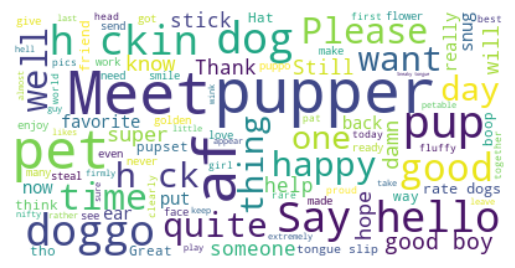

In [1311]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str(df_word.text.tolist()))
plt.figure()
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

### Insights 4:
I can see some keywords like good, well, great, help, happy, quite, favorite, friend. I think most of people really like these 3 breeds because they are friendly, happy, and people can make a friend with them.

## Resource
- https://blog.hubspot.com/website/drop-multiple-columns-pandas
- https://sparkbyexamples.com/pandas/pandas-convert-string-column-to-datetime/
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
- https://www.datacamp.com/tutorial/elif-statements-python?utm_source=google&utm_medium=paid_search&utm_campaignid=19589720824&utm_adgroupid=143216588537&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=645433043013&utm_targetid=aud-392016246653:dsa-1947282172981&utm_loc_interest_ms=&utm_loc_physical_ms=1028581&utm_content=dsa~page~community-tuto&utm_campaign=230119_1-sea~dsa~tutorials_2-b2c_3-row-p2_4-prc_5-na_6-na_7-le_8-pdsh-go_9-na_10-na_11-na&gclid=Cj0KCQjw7PCjBhDwARIsANo7Cgk4OJuC6mAKbtF08WhOWPdGGLIO7xRpM84cOj0Xcgxcj7ZS5gN_bCYaAreREALw_wcB
- https://pbpython.com/text-cleaning.html
- https://stackoverflow.com/questions/62703844/cleaning-text-in-a-pandas-column
- https://stackoverflow.com/questions/6116978/how-to-replace-multiple-substrings-of-a-string
- https://pandas.pydata.org/docs/reference/api/pandas.melt.html
- https://stackoverflow.com/questions/13411544/delete-a-column-from-a-pandas-dataframe
- https://stackoverflow.com/questions/17181631/efficient-way-to-extract-text-from-between-tags
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html#pandas.DataFrame.apply
- https://www.datacamp.com/tutorial/wordcloud-python